# Social Doors Cerebellum PPI Analysis

Author: Haroon Popal 

Code borrowed from [dartbrains](https://dartbrains.org/content/Connectivity.html#psychophysiological-interactions)

## Set Up

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation, zscore
from sklearn.metrics import pairwise_distances

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img

import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [2]:
def plot_stat_contours(filename, thresh=1, alpha=0.05, view='split', title=''):
    # Find type of analysis
    analysis = 'group_results'
    
    # Find stat map
    stat_filename = os.path.join(outp_dir, analysis,  
                                    filename+'_unc.nii.gz')
    stat_filename_mc = os.path.join(outp_dir, analysis,  
                                    filename+'_fdr'+str(alpha)+'.nii.gz')
    
    mc_thresh = threshold_data[filename+'_fdr_0.05']
    if mc_thresh == np.inf:
        mc_thresh = 1000

    if view == 'split':
        hemi_lh = plot_stat_map(stat_filename, threshold=thresh, 
                      cut_coords=range(-65,0, 10), display_mode='x', colorbar=True,
                      cmap='coolwarm', symmetric_cbar=True, title='Left Hemisphere')
        hemi_rh = plot_stat_map(stat_filename, threshold=thresh, 
                      cut_coords=range(66,5, -10), display_mode='x', colorbar=True,
                      cmap='coolwarm', symmetric_cbar=True, title='Right Hemisphere')
        hemi_lh.add_contours(stat_filename_mc, levels=[-mc_thresh,mc_thresh], colors=['blue','red'], 
                          alpha=1, linewidths=2)
        hemi_rh.add_contours(stat_filename_mc, levels=[-mc_thresh,mc_thresh], colors=['blue','red'], 
                          alpha=1, linewidths=2)
        
    elif view == 'straight':
        hemi_bh = plot_stat_map(stat_filename, threshold=thresh, 
                      cut_coords=range(-65,66, 10), display_mode='x', colorbar=True,
                      cmap='coolwarm', symmetric_cbar=True, title=title)
        hemi_bh.add_contours(stat_filename_mc, levels=[-mc_thresh,mc_thresh], colors=['blue','red'], 
                          alpha=1, linewidths=2)

### Set Paths

In [3]:
bids_dir = '/Users/haroonpopal/OneDrive - Temple University/olson_lab/projects/social_doors/'
os.chdir(bids_dir)

outp_dir = os.path.join(bids_dir, 'derivatives', 'ppi_analysis')
data_dir = os.path.join(bids_dir, 'derivatives','social_doors-nilearn')

if os.path.exists(outp_dir):
    print('Output directory already exists. Continuing will overwrite data.')
else:
    os.makedirs(outp_dir)

Output directory already exists. Continuing will overwrite data.


### Import participant list

In [4]:
subjs_scan_info = pd.read_csv(bids_dir+'derivatives/participants_good.tsv', sep='\t')

subjs_list = list(subjs_scan_info['participant_id'].unique())
len(subjs_list)

subjs_list.sort()
print('Found '+str(len(subjs_list))+' subjects')
subj = subjs_list[0]

Found 63 subjects


In [5]:
subjs_scan_info

,Unnamed: 0,participant_id,age,sex,group
0,0,sub-010,13,F,kid
1,2,sub-013,13,M,kid
2,5,sub-028,15,M,kid
3,6,sub-036,16,F,kid
4,7,sub-5049,12,F,kid
...,...,...,...,...,...
58,76,sub-4069,22,F,college
59,77,sub-6003,23,M,college
60,78,sub-6004,19,M,college
61,79,sub-6005,21,F,college


### Import MRI quality control info

In [6]:
qc_summary = pd.read_csv('derivatives/qc_summary.csv')

# Filter qc summary for only good participants
qc_summary_good = qc_summary[qc_summary['subject'].isin(subjs_list)]
qc_summary_good.head()

,subject,run,rating,artifacts
0,sub-010,mdoors_run-1,4,[]
1,sub-010,mdoors_run-2,3,['head-motion']
2,sub-010,social_run-1,4,[]
3,sub-010,social_run-2,4,[]
8,sub-013,mdoors_run-1,3,"['head-motion','parietal-cutoff']"


# Single Subject Analysis
This will complete the PPI analysis for a single subject to explain each step of the process, before running for all participants

## Set up task info

In [7]:
task = 'social'

func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
func_run_names = func_run_names['run'].to_list()

## Find functional data

In [8]:
# Find functinoal runs that passed quality control
func_runs = []
for run in func_run_names:
    func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'func',
                                   subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])

# Set a grey matter mask
subj_gm_mask = 'derivatives/fmriprep/'+subj+'/anat/'+subj+'_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'
data = Brain_Data(func_runs, mask=subj_gm_mask)

# Smooth data
fwhm=6
smoothed = data.smooth(fwhm=fwhm)

## Set an ROI
The region of interest (ROI) used here is "region 8" from the MDTB cerebellum atlas from [King et al., 2019](https://www.nature.com/articles/s41593-019-0436-x).

In [9]:
roi_names = ['region08']

rois_dict = {}

for n in range(len(roi_names)):
    roi_path = glob.glob(os.path.join(bids_dir, 'derivatives','rois',
                                                    'mdtb_'+roi_names[n]+'.nii.gz'))
    rois_dict[roi_names[n]] = Brain_Data(roi_path, mask=subj_gm_mask)

## Extract Data

Text(0.5, 0, 'Time (TRs)')

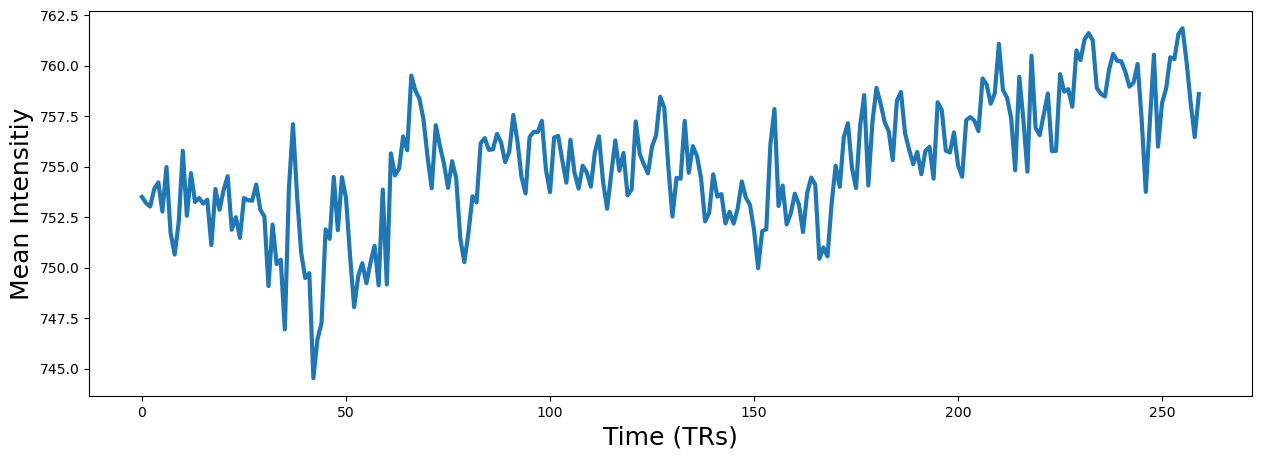

In [10]:
cb_data = smoothed.extract_roi(mask=rois_dict['region08'])

plt.figure(figsize=(15,5))
plt.plot(cb_data, linewidth=3)
plt.ylabel('Mean Intensitiy', fontsize=18)
plt.xlabel('Time (TRs)', fontsize=18)

## Create design matrix

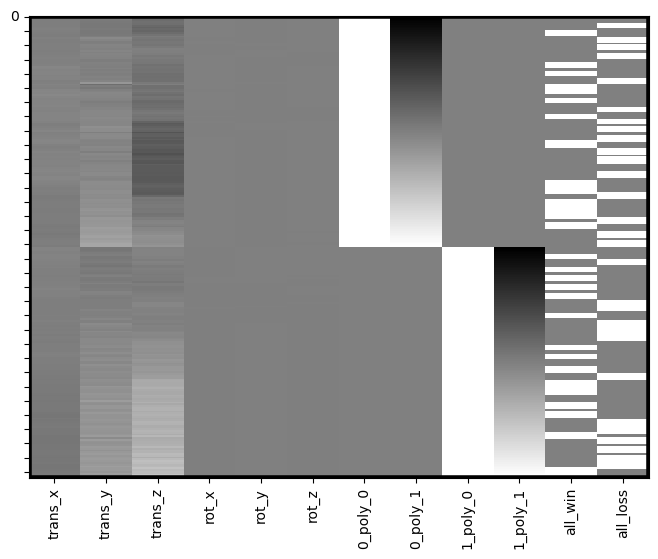

In [32]:
# Set TR info
tr = 2.1
n_tr = len(data)

# z-score cerebellum time series
cb_data = zscore(pd.DataFrame(cb_data, columns=['region08']))


# Append run design matrices
dm = pd.DataFrame()
for run in func_run_names:
    run_n = int(run[-1])
    
    # Import design matrix for a single run
    temp_dm = pd.read_csv(outp_dir+'/design_matrices/'+subj+'_task-'+run+'_desc-design_matrix.csv')

    # Rename the first and second order polynomial regressors so that they do not 
    # regressor between runs
    temp_dm = temp_dm.rename(columns={"poly_0": str(run_n-1)+"_poly_0", "poly_1": str(run_n-1)+"_poly_1"})
    
    # Append design matrix into a longer design matrix
    dm = pd.concat([dm, temp_dm], ignore_index=True)


# Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
dm = dm.fillna(0)

# Join Design matrix with roi time course
dm = Design_Matrix(pd.concat([cb_data, dm], axis=1), sampling_freq=1/tr)


# Create all win and all loss. conditions
dm['all_win'] = dm['positive_win'] + dm['negative_win']
dm['all_loss'] = dm['positive_loss'] + dm['negative_loss']

# Remove irrelevant conditions and create a new dm
ppi_dm = dm.drop(['positive_win', 'positive_loss',
                  'negative_win', 'negative_loss', 
                  'negative', 'positive', 
                  'fixation', 'region08'], axis=1)


# Plot design matrix
ppi_dm.heatmap()

## Psychophysiological Interaction Analysis

### Add region x condition interaction terms
For this analysis we will use a generalized PPI framework in which we take the interaction of each condition of interest with the time series of an ROI

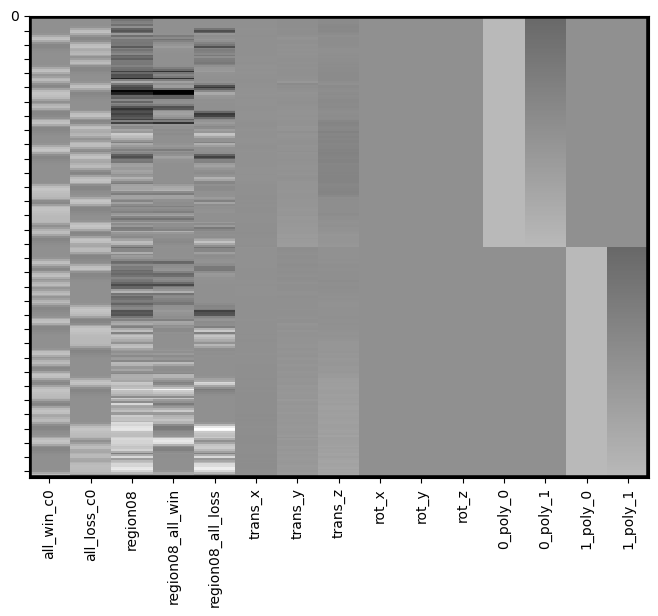

In [33]:
# Find motion regressors
mc_cov = ppi_dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]

# Find polynomial regressors
poly_cov = ppi_dm.loc[:, ppi_dm.columns.str.contains('_poly_')]

# Remove motion and polynomial regressors
ppi_dm = ppi_dm.drop(mc_cov.columns, axis=1)
ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)

# Complete convolution
ppi_dm_conv = ppi_dm.convolve()

# Add ROI time series
ppi_dm_conv['region08'] = cb_data


# Create generalized interaction terms
ppi_dm_conv['region08_all_win'] = ppi_dm_conv['region08']*ppi_dm_conv['all_win_c0']
ppi_dm_conv['region08_all_loss'] = ppi_dm_conv['region08']*ppi_dm_conv['all_loss_c0']


ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)


ppi_dm_conv_all.heatmap()

### Regress onto the whole brain

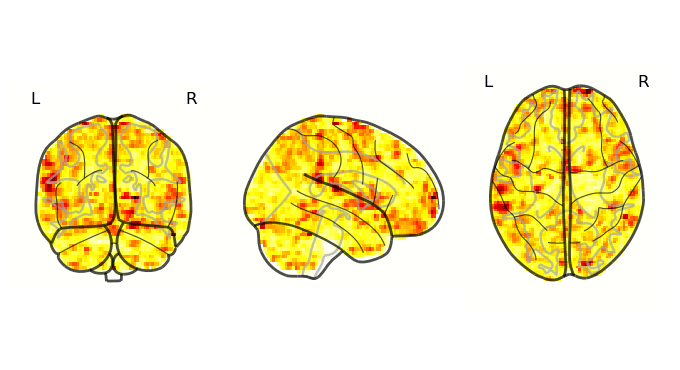

In [51]:
smoothed.X = ppi_dm_conv_all

ppi_stats = smoothed.regress()

# Create all win vs all loss PPI contrast
c1 = np.zeros(len(ppi_stats['beta']))
idx_1 = list(smoothed.X.columns).index('region08_all_win')
idx_2 = list(smoothed.X.columns).index('region08_all_loss')

c1[idx_1] = 1
c1[idx_2] = -1


cb_r_fixation_ppi = ppi_stats['beta'] * c1

#cb_r_fixation_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='region08_all_win')[0][0])]

#cb_r_fixation_ppi.plot()
plot_glass_brain(cb_r_fixation_ppi.to_nifti())

# Group PPI Analysis

In [54]:
# Remove bad participant
subjs_list = [x for x in subjs_list if x != 'sub-4069']

In [55]:
all_sub_ppi_cb = Brain_Data()

task = 'social'
roi = 'region08'

for subj in subjs_list:
    print('Calculating PPI for '+subj)
    
    # Import functional runs that passed quality control
    #func_run_nums =  [s.lstrip('0') for s in subjs_scan_info[subjs_scan_info['subject']==subj]['run'].str[-8:-5]]
    #func_run_nums = [int(i) for i in func_run_nums]
    func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
    func_run_names = func_run_names['run'].to_list()
    
    print('Number of functional runs for '+subj+': '+str(len(func_run_names)))

    # Find functional runs that passed quality control
    func_runs = []
    for run in func_run_names:
        func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'func',
                                   subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])
    
    
    # Import functional data, masked for only grey matter
    mni_gm_mask = 'derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'
    #comn_mni_mask = "derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    data = Brain_Data(func_runs, mask=mni_gm_mask)
    
    
    # Smooth data
    fwhm=6
    smoothed = data.smooth(fwhm=fwhm)
    
    
    # Extract cerebellum ROI data
    cb_data = smoothed.extract_roi(mask=rois_dict[roi])
    
    
    # Get functional meta data
    #tr = layout.get_tr()
    n_tr = len(data)
    
    
    # Z-score cerebellum time series
    cb_data = zscore(pd.DataFrame(cb_data, columns=[roi]))

    
    # Import Design matrix for all runs
    #dm = pd.read_csv(bids_dir+'/derivatives/fmriprep/'+subj+'/ses-001/func/'+subj+'_ses-001_task-relscenarios_run-all_cat_desc-design_matrix.csv')
    #cb_data_dm = Design_Matrix(cb_data, sampling_freq=1/tr).convolve()
    dm = pd.DataFrame()
    for run in func_run_names:
        run_n = int(run[-1])
        # Import design matrix for a single run
        temp_dm = pd.read_csv(outp_dir+'/design_matrices/'+subj+'_task-'+run+'_desc-design_matrix.csv')
        # Rename the first and second order polynomial regressors so that they do not 
        # regressor between runs
        temp_dm = temp_dm.rename(columns={"poly_0": str(run_n-1)+"_poly_0", "poly_1": str(run_n-1)+"_poly_1"})

        # Append design matrix into a longer design matrix
        #dm = dm.append(temp_dm, ignore_index=True)
        dm = pd.concat([dm, temp_dm], ignore_index=True)
        
    # Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
    dm = dm.fillna(0)
    
    # Combine cerebellum time series with the design matrix
    #ppi_dm = Design_Matrix(pd.concat([cb_data, dm], axis=1), sampling_freq=1/tr)
    
    # Create all win and all loss. conditions
    dm['all_win'] = dm['positive_win'] + dm['negative_win']
    dm['all_loss'] = dm['positive_loss'] + dm['negative_loss']

    # Remove irrelevant conditions and create a new dm
    dm = dm.drop(['positive_win', 'positive_loss',
                      'negative_win', 'negative_loss', 
                      'negative', 'positive', 
                      'fixation'], axis=1)
    

    #ppi_dm = dm.drop(['CB_r'], axis=1)

    mc_cov = dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
    poly_cov = dm.loc[:, dm.columns.str.contains('_poly_')]

    ppi_dm = dm.drop(mc_cov.columns, axis=1)
    ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)
    
    ppi_dm = Design_Matrix(ppi_dm, sampling_freq=1/tr)
    ppi_dm_conv = ppi_dm.convolve()

    ppi_dm_conv[roi] = cb_data

    # Create generalized interaction terms
    ppi_dm_conv['region08_all_win'] = ppi_dm_conv['region08']*ppi_dm_conv['all_win_c0']
    ppi_dm_conv['region08_all_loss'] = ppi_dm_conv['region08']*ppi_dm_conv['all_loss_c0']

    ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)
    
    
    # Convolve design matrix
    #ppi_dm_conv = ppi_dm.convolve()
    
    
    # Calculate interaction term
    #ppi_dm_conv['CB_r_All'] = ppi_dm_conv['CB_r_c0']*ppi_dm_conv['All_c0']
    
    
    # Run PPI
    smoothed.X = ppi_dm_conv_all
    ppi_stats = smoothed.regress()
    
    # Create all win vs all loss PPI contrast
    c1 = np.zeros(len(ppi_stats['beta']))
    idx_1 = list(smoothed.X.columns).index('region08_all_win')
    idx_2 = list(smoothed.X.columns).index('region08_all_loss')

    c1[idx_1] = 1
    c1[idx_2] = -1

    # Calculate contrast
    cb_r_fixation_ppi = ppi_stats['beta'] * c1
    
    
    # Export PPI map
    cb_r_fixation_ppi.to_nifti().to_filename(outp_dir+'/subject_results/'+subj+'_ppi_'+roi+'.nii.gz')
    
    
    # Append subject data
    all_sub_ppi_cb = all_sub_ppi_cb.append(cb_r_fixation_ppi)

Calculating PPI for sub-010
Number of functional runs for sub-010: 2
Calculating PPI for sub-013
Number of functional runs for sub-013: 2
Calculating PPI for sub-028
Number of functional runs for sub-028: 2
Calculating PPI for sub-036
Number of functional runs for sub-036: 2
Calculating PPI for sub-3845
Number of functional runs for sub-3845: 2
Calculating PPI for sub-3846
Number of functional runs for sub-3846: 2
Calculating PPI for sub-3848
Number of functional runs for sub-3848: 2
Calculating PPI for sub-3849
Number of functional runs for sub-3849: 2
Calculating PPI for sub-3852
Number of functional runs for sub-3852: 2
Calculating PPI for sub-3855
Number of functional runs for sub-3855: 2
Calculating PPI for sub-3864
Number of functional runs for sub-3864: 2
Calculating PPI for sub-3865
Number of functional runs for sub-3865: 2
Calculating PPI for sub-3874
Number of functional runs for sub-3874: 2
Calculating PPI for sub-3880
Number of functional runs for sub-3880: 2
Calculating PP

# All Participants Group Average

## Set 2nd level parameters

In [56]:
# Define a grey matter mask
subj_mni_mask = bids_dir+'/derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'
# Define alpha for multiple comparisons correction
alpha = 0.05

In [57]:
threshold_data = {}

# Find subject maps for a given feature
file_list = glob.glob(os.path.join(outp_dir, 'subject_results', '*_ppi_region08.nii.gz'))
file_list.sort()

# Create a design matrix of just one column
design_matrix = pd.DataFrame([1] * len(file_list), columns=["intercept"])
    
# Create second level model and fit the data and design matrix
model = SecondLevelModel(mask_img=subj_mni_mask, smoothing_fwhm=8.0)
model.fit(file_list, design_matrix=design_matrix)

#Compute a contrast map to see whether any regions are greater than 0
z_map = model.compute_contrast(output_type='z_score')
z_map.to_filename(os.path.join(outp_dir, 'group_results','zmap_ppi_region08_unc.nii.gz'))
            
# Multiple Comparisons Correction
z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control='fdr')
z_map_thresh.to_filename(os.path.join(outp_dir, 'group_results', 
                                      'zmap_ppi_region08_fdr'+str(alpha)+'.nii.gz'))
            
threshold_data['zmap_ppi_region08_fdr_'+str(alpha)] = threshold

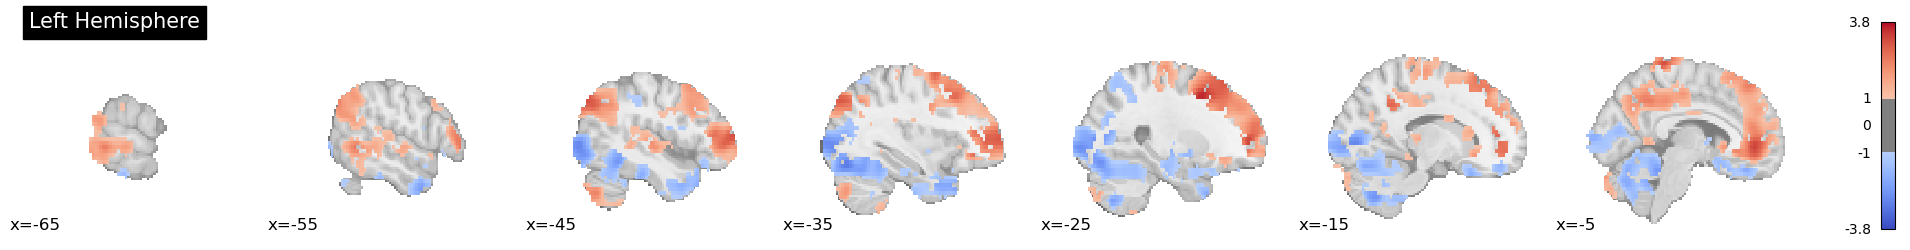

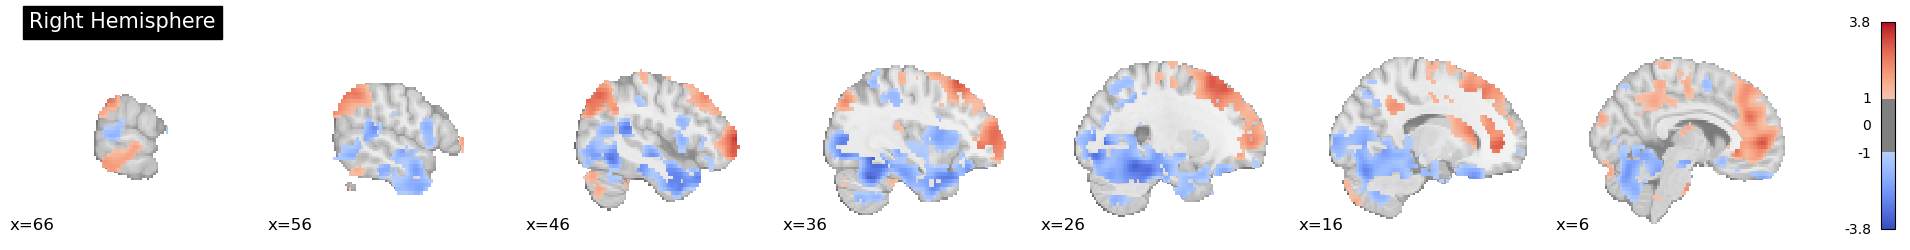

In [58]:
plot_stat_contours('zmap_ppi_region08', thresh=1)

**Results:** No significant clusters, but a more liberal threshold shows more positive correlations between Crus I/II with vmPFC, dlPFC, and more negative correlation with the ventral stream for all wins than for all losses.

## Young Adults

In [59]:
subjs_scan_info = subjs_scan_info[subjs_scan_info['participant_id'] != 'sub-4069']

In [60]:
# Create list of young adult data
subjs_scan_info_adult = subjs_scan_info[subjs_scan_info['group'] == 'college']
print('There are ' + str(len(subjs_scan_info_adult))+ ' young adults')

# Find PPI maps
file_list_adult_ppi = []

for subj in subjs_scan_info_adult['participant_id']:
    file_list_adult_ppi.append(glob.glob(os.path.join(outp_dir+'/subject_results/'+subj+'_ppi_region08.nii.gz'))[0])


print('Found '+str(len(file_list_adult_ppi))+' subject maps')

There are 30 young adults
Found 30 subject maps


In [61]:
# Create a design matrix of just one column
design_matrix = pd.DataFrame([1] * len(file_list_adult_ppi), columns=["intercept"])
    
# Create second level model and fit the data and design matrix
model = SecondLevelModel(mask_img=subj_mni_mask, smoothing_fwhm=8.0)
model.fit(file_list_adult_ppi, design_matrix=design_matrix)

#Compute a contrast map to see whether any regions are greater than 0
z_map = model.compute_contrast(output_type='z_score')
z_map.to_filename(os.path.join(outp_dir, 'group_results','zmap_ppi_region08_adult_unc.nii.gz'))
            
# Multiple Comparisons Correction
z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control='fdr')
z_map_thresh.to_filename(os.path.join(outp_dir, 'group_results', 
                                      'zmap_ppi_region08_adult_fdr'+str(alpha)+'.nii.gz'))
            
threshold_data['zmap_ppi_region08_adult_fdr_'+str(alpha)] = threshold

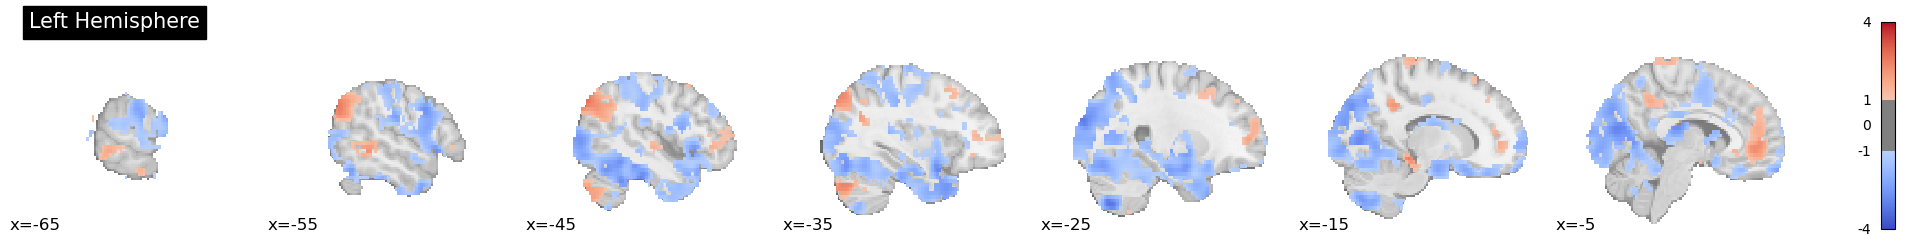

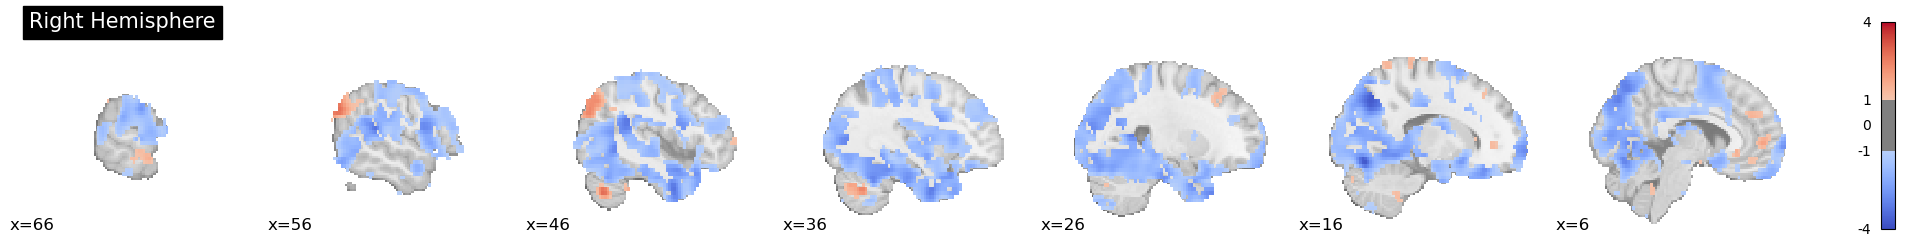

In [62]:
plot_stat_contours('zmap_ppi_region08_adult', thresh=1)

**Results:** No significant clusters. But liberal threshold shows stronger positive correlations between Crus I/II in the cerebellum and the TPJ, dlPFC, vmPFC, and stronger negative correlations with the dorsal and ventral streams for all wins than for all losses.

## Adolescents

In [63]:
# Create list of young adult data
subjs_scan_info_adole = subjs_scan_info[subjs_scan_info['group'] == 'kid']
print('There are ' + str(len(subjs_scan_info_adole))+ ' adolescents')

# Find PPI maps
file_list_adole_ppi = []

for subj in subjs_scan_info_adole['participant_id']:
    file_list_adole_ppi.append(glob.glob(os.path.join(outp_dir+'/subject_results/'+subj+'_ppi_region08.nii.gz'))[0])


print('Found '+str(len(file_list_adole_ppi))+' subject maps')

There are 32 adolescents
Found 32 subject maps


In [64]:
# Create a design matrix of just one column
design_matrix = pd.DataFrame([1] * len(file_list_adole_ppi), columns=["intercept"])
    
# Create second level model and fit the data and design matrix
model = SecondLevelModel(mask_img=subj_mni_mask, smoothing_fwhm=8.0)
model.fit(file_list_adole_ppi, design_matrix=design_matrix)

#Compute a contrast map to see whether any regions are greater than 0
z_map = model.compute_contrast(output_type='z_score')
z_map.to_filename(os.path.join(outp_dir, 'group_results','zmap_ppi_region08_adole_unc.nii.gz'))
            
# Multiple Comparisons Correction
z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control='fdr')
z_map_thresh.to_filename(os.path.join(outp_dir, 'group_results', 
                                      'zmap_ppi_region08_adole_fdr'+str(alpha)+'.nii.gz'))
            
threshold_data['zmap_ppi_region08_adole_fdr_'+str(alpha)] = threshold

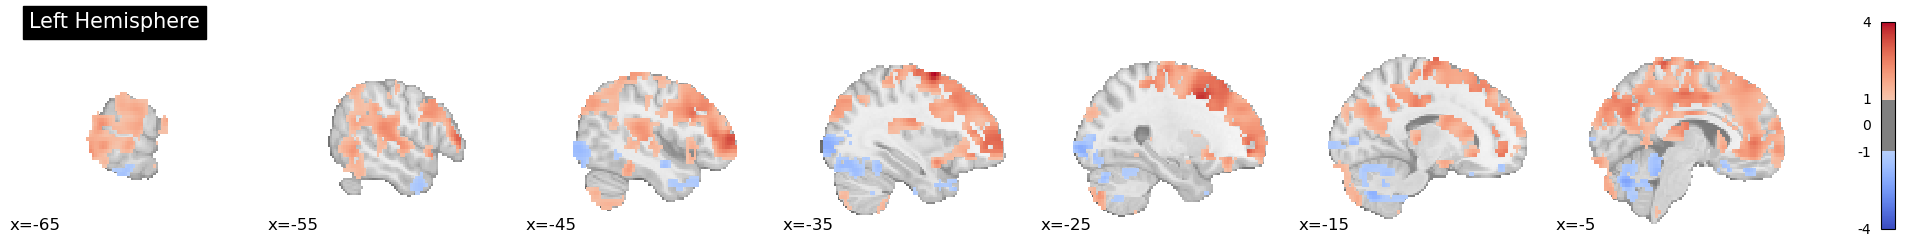

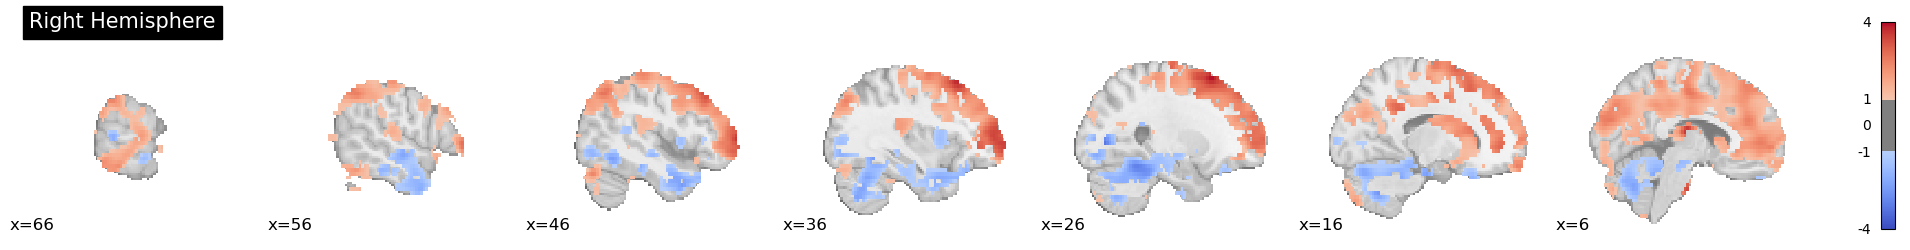

In [65]:
plot_stat_contours('zmap_ppi_region08_adole', thresh=1)

**Results:** No significant clusters. However, a liberal thershold shows greater positive correlations between Crus I/II and the frontal pole for all wins than for losses.

# Between Groups

## Second Level Design Matrix

<Axes: label='conditions', ylabel='scan number'>

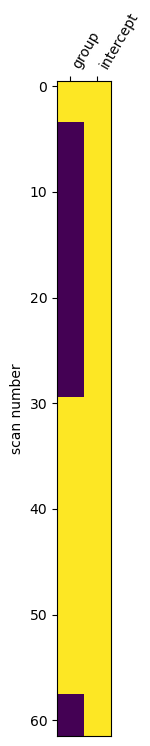

In [66]:
# Make a copy for the design matrix df
subjs_info_num = subjs_scan_info.copy()

# Turn values numeric
subjs_info_num = subjs_info_num.replace({'group': {'college': -1, 'kid': 1}})

# Remove irrelevant info
subjs_info_num = subjs_info_num.drop(columns=['age', 'sex', 'Unnamed: 0'])

# Change column header for needed function input
subjs_info_num = subjs_info_num.rename({'participant_id':'subject_label'}, axis='columns')

design_matrix = make_second_level_design_matrix(subjs_list, subjs_info_num)

plot_design_matrix(design_matrix)

In [67]:
# Find PPI data
file_list = []
for subj in subjs_list:
    file_list.append(glob.glob(os.path.join(outp_dir+'/subject_results/'+subj+'_ppi_region08.nii.gz'))[0])

# Create second level model
model = SecondLevelModel(mask_img=mni_gm_mask, smoothing_fwhm=8.0)
model.fit(file_list, design_matrix=design_matrix)

#Compute a contrast map to see whether any regions are greater than 0
z_map = model.compute_contrast('group', output_type='z_score')
z_map.to_filename(os.path.join(outp_dir, 'group_results','zmap_ppi_region08_adoleVadult_unc.nii.gz'))
            
# Multiple Comparisons Correction
z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control='fdr')
z_map_thresh.to_filename(os.path.join(outp_dir, 'group_results', 
                                      'zmap_ppi_region08_adoleVadult_fdr'+str(alpha)+'.nii.gz'))
            
threshold_data['zmap_ppi_region08_adoleVadult_fdr_'+str(alpha)] = threshold

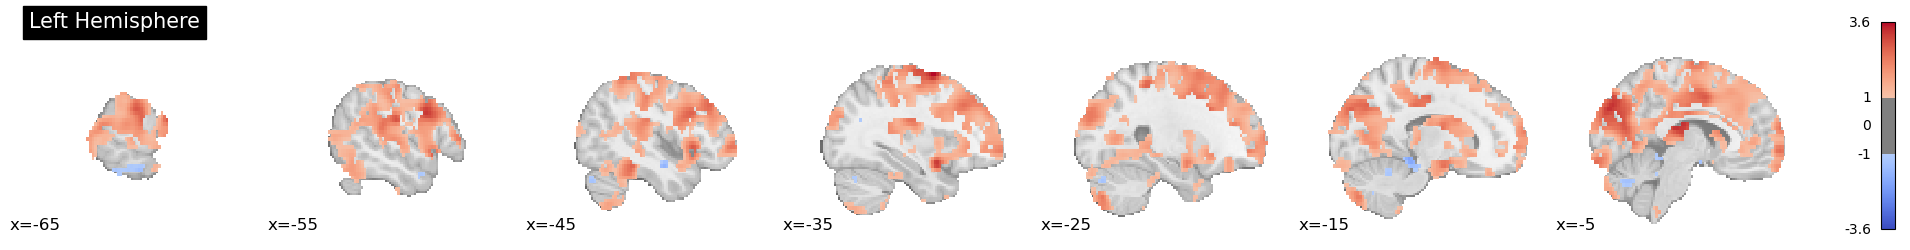

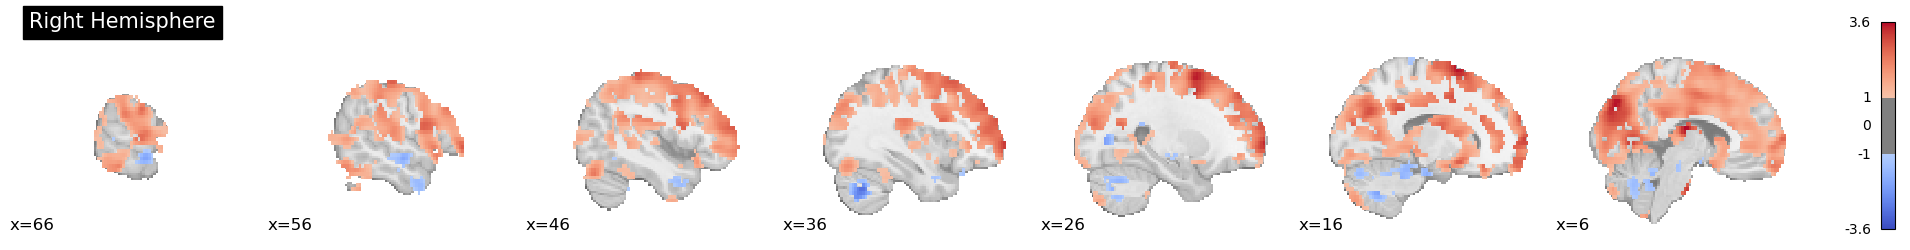

In [68]:
plot_stat_contours('zmap_ppi_region08_adoleVadult', thresh=1)

**Results:** No significant differences between adolescent and young adult connectivity between Crus I/II and the rest of the brain for all wins vs all losses. However, a liberal threshold shows stronger connectivity in the frontal pole and early visual cortex.

# Summary

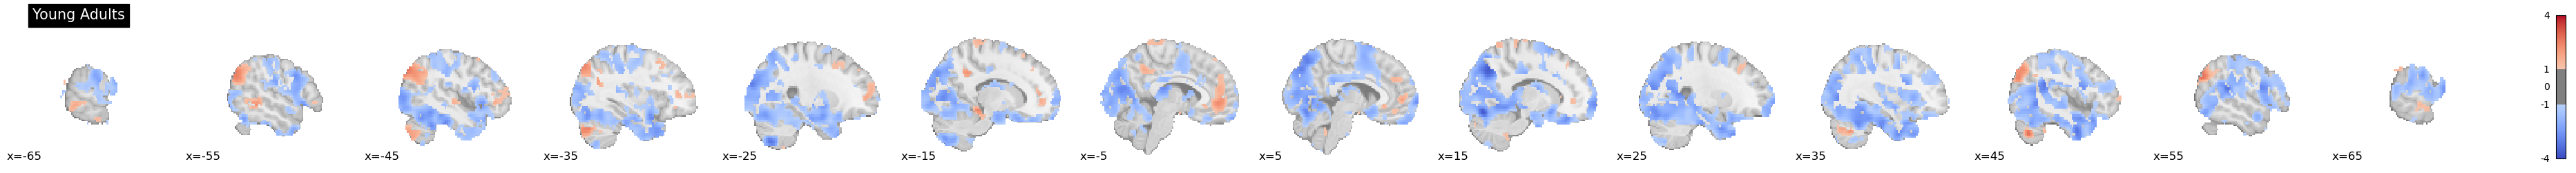

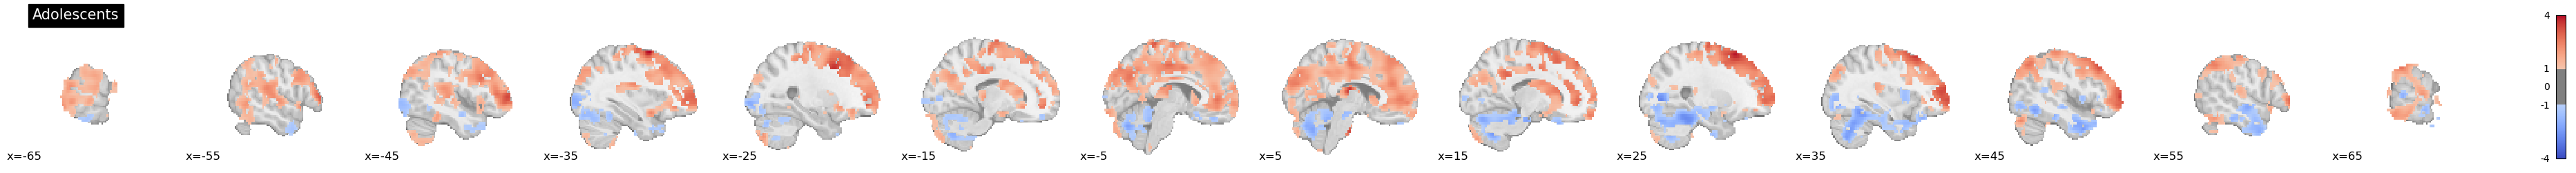

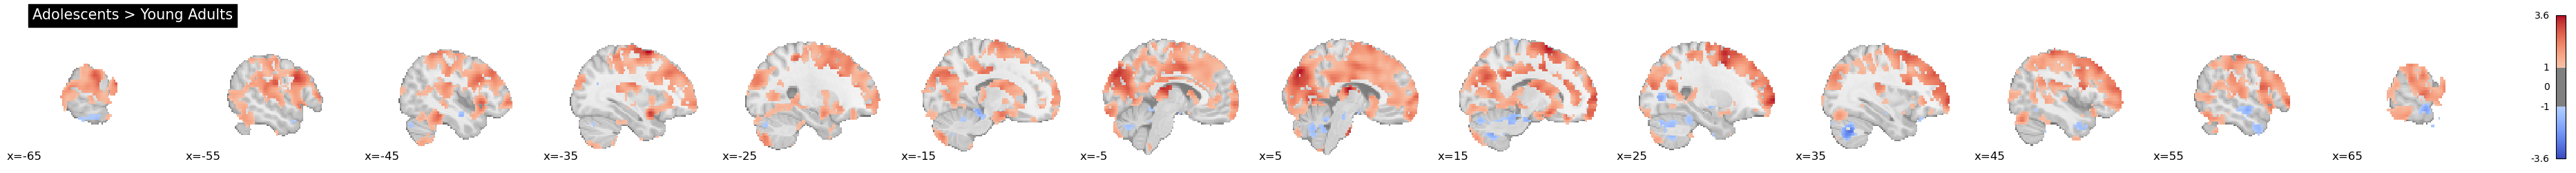

In [69]:
plot_stat_contours('zmap_ppi_region08_adult', thresh=1, view='straight', 
                   title='Young Adults')
plot_stat_contours('zmap_ppi_region08_adole', thresh=1, view='straight', 
                   title='Adolescents')
plot_stat_contours('zmap_ppi_region08_adoleVadult', thresh=1, view='straight', 
                   title='Adolescents > Young Adults')

Overall, there were no significant results after multiple comparisons correction (FDR < .05). However, some interesting trends hint at differences in Crus I/II connectivity with the cerebrum between adolescents and young adults for win trials over loss trials of the task. Connectivity between Crus I/II and the dlPFC, striatum, and early visual cortex is greater in adolescents than in young adults. This connectivity does not change significantly, when account for activity in either the reward or social networks.